# Object localization using transfer learning - PASCAL VOC dataset

## Data Collection

In [ ]:
!wget -q http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar

In [ ]:
!tar -xvf VOCtrainval_06-Nov-2007.tar > /dev/null; echo " done."

 done.


In [ ]:
!wget -q https://raw.githubusercontent.com/anshupandey/Computer-Vision/master/Object%20Localization/PASCAL_VOC_labels.p

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models,layers
from tensorflow.keras.applications import resnet50
from tensorflow.keras.preprocessing import image
import os

In [ ]:
df = pd.read_pickle("/content/PASCAL_VOC_labels.p")
df.head()

,file_name,category,cat_id,bbox
0,000012.jpg,car,6,"[96, 155, 269, 350]"
1,000017.jpg,horse,12,"[77, 89, 335, 402]"
2,000023.jpg,person,14,"[1, 2, 461, 242]"
3,000026.jpg,car,6,"[124, 89, 211, 336]"
4,000032.jpg,aeroplane,0,"[77, 103, 182, 374]"


In [ ]:
main_folder = "/content/VOCdevkit/VOC2007/JPEGImages"

In [ ]:
imm = plt.imread(main_folder + "/" + df.file_name[0])
print(imm.shape)
print(df.bbox[0])
plt.imshow(imm)
plt.show()

In [ ]:
imm = plt.imread(main_folder + "/" + df.file_name[8])
print(imm.shape)
bb = df.bbox[8]
print(bb)
plt.imshow(imm)
plt.show()

In [ ]:
from imgaug import augmenters as ag
import imgaug as ig

In [ ]:
augobj = ag.Resize({"height":150,"width":150}).to_deterministic()
old_bb = ig.BoundingBoxesOnImage([ig.BoundingBox(x1=bb[1],x2=bb[3],y1=bb[0],y2=bb[2])],shape=imm.shape)

new_img = augobj.augment_images([imm])[0]
print(new_img.shape)
new_bb = augobj.augment_bounding_boxes([old_bb])[0].bounding_boxes[0]
new_bb = [new_bb.x1,new_bb.y1,new_bb.x2,new_bb.y2]
print(new_bb)

(150, 150, 3)
[11.746988, 23.4, 143.6747, 102.9]


In [ ]:
augobj = ag.Resize({"height":150,"width":150}).to_deterministic()
def augment(img,bb):
  old_bb = ig.BoundingBoxesOnImage([ig.BoundingBox(x1=bb[1],x2=bb[3],y1=bb[0],y2=bb[2])],shape=img.shape)
  new_img = augobj.augment_images([img])[0]
  new_bb = augobj.augment_bounding_boxes([old_bb])[0].bounding_boxes[0]
  new_bb = [new_bb.x1,new_bb.y1,new_bb.x2,new_bb.y2]
  return new_img,new_bb


In [ ]:
df.head()

In [ ]:
sorted(df.cat_id.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

In [ ]:
x = []
y1 = [] # all the classification labels
y2 = [] # all the regression labels
for i in range(df.shape[0]):
  img = plt.imread(main_folder + "/" + df.file_name[i])
  img,bb = augment(img,df.bbox[i])
  img = resnet50.preprocess_input(img)
  x.append(img)
  y1.append(df.cat_id[i])
  y2.append(bb)



In [ ]:
x = np.array(x)
y1 = to_categorical(y1)
y2 = np.array(y2)
print(x.shape)
print(y1.shape)
print(y2.shape)

(2501, 150, 150, 3)
(2501, 20)
(2501, 4)


### Modelling the CNN

In [ ]:
from tensorflow.keras import models,layers

In [ ]:
input_layer = layers.Input(shape=(150,150,3))
resmodel = resnet50.ResNet50(weights='imagenet',include_top=False,input_tensor=input_layer)

current_output_layer = resmodel.output

ft = layers.Flatten()(current_output_layer)

#classification section
dp = layers.Dropout(0.5)(ft)
h1 = layers.Dense(300,activation='relu')(dp)
dp = layers.Dropout(0.3)(h1)
op1 = layers.Dense(20,activation='softmax',name='cls')(dp)

#regression section
dp = layers.Dropout(0.5)(ft)
h2 = layers.Dense(200,activation='relu')(dp)
dp = layers.Dropout(0.3)(h2)
op2 = layers.Dense(4,activation='relu',name='reg')(dp)

model = models.Model(inputs=input_layer,outputs=[op1,op2])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 75, 75, 64)   256         conv1_conv[0][0]                 
____________________________________________________________________________________________

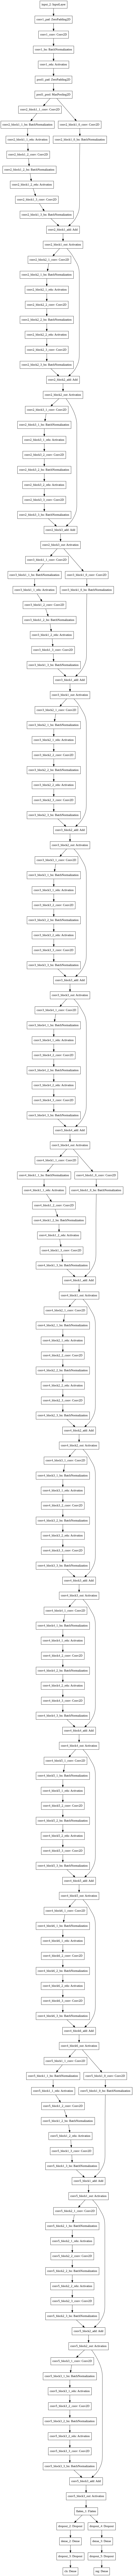

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model)

In [ ]:
model.compile(metrics={'cls':'accuracy'},loss={'cls':'categorical_crossentropy','reg':'mae'},
              loss_weights={'cls':3,'reg':1},
              optimizer='adam')
model.fit(x=x,y=[y1,y2],epochs=10,validation_split=0.2,batch_size=64)

Epoch 1/10
32/32 [==============================] - 17s 386ms/step - loss: 44.5744 - cls_loss: 4.3796 - reg_loss: 31.4357 - cls_accuracy: 0.2405 - val_loss: 212.0094 - val_cls_loss: 6.0610 - val_reg_loss: 193.8266 - val_cls_accuracy: 0.0958
Epoch 2/10
32/32 [==============================] - 12s 362ms/step - loss: 28.5520 - cls_loss: 2.0446 - reg_loss: 22.4183 - cls_accuracy: 0.3865 - val_loss: 118.4125 - val_cls_loss: 9.0706 - val_reg_loss: 91.2007 - val_cls_accuracy: 0.0499
Epoch 3/10
32/32 [==============================] - 12s 366ms/step - loss: 26.6278 - cls_loss: 1.7727 - reg_loss: 21.3097 - cls_accuracy: 0.4740 - val_loss: 151.1006 - val_cls_loss: 10.2243 - val_reg_loss: 120.4277 - val_cls_accuracy: 0.0659
Epoch 4/10
32/32 [==============================] - 12s 369ms/step - loss: 25.2718 - cls_loss: 1.5532 - reg_loss: 20.6122 - cls_accuracy: 0.5285 - val_loss: 180.5095 - val_cls_loss: 9.9689 - val_reg_loss: 150.6027 - val_cls_accuracy: 0.2695
Epoch 5/10
32/32 [==================

In [ ]:
!wget -q https://img.freepik.com/free-photo/young-handsome-man-with-beard-isolated-keeping-arms-crossed-frontal-position_1368-132662.jpg

In [ ]:
img = image.img_to_array(image.load_img("young-handsome-man-with-beard-isolated-keeping-arms-crossed-frontal-position_1368-132662.jpg",target_size=(150,150)))
img2 = img.copy()
img = resnet50.preprocess_input(img)
pred = model.predict(img.reshape(1,150,150,3))

print(pred)

[array([[6.3678782e-09, 3.6688301e-09, 1.1682524e-06, 2.4391946e-07,
        4.6221404e-10, 1.1621896e-06, 1.6611630e-06, 1.5577532e-05,
        8.1417866e-06, 2.3005582e-10, 3.3103090e-10, 3.1397693e-05,
        9.0572257e-06, 5.6676286e-06, 9.9992585e-01, 3.4486278e-11,
        2.8750986e-09, 2.9687455e-10, 1.0853924e-08, 1.2578740e-09]],
      dtype=float32), array([[ 24.493727,  15.066609, 129.56319 , 177.10089 ]], dtype=float32)]


In [ ]:
cl = np.argmax(pred[0][0])
print(cl)
df.category[df.cat_id==cl].unique()

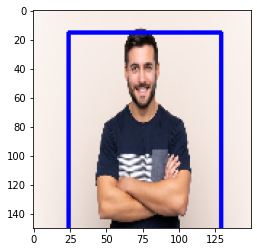

In [ ]:
import cv2
bb = pred[1][0]
cv2.rectangle(img2,(bb[0],bb[1]),(bb[2],bb[3]),[0,0,255],2)
plt.imshow(img2.astype('int32'))
plt.show()

In [ ]:
pred[1]

array([[36.992935, 32.00333 , 73.91298 , 81.51849 ]], dtype=float32)

In [ ]:
img.shape

(150, 150, 3)